In [1]:
import torch
import dataio, meta_modules, utils, training, loss_functions, modules
from torch.utils.data import DataLoader
import configargparse
from functools import partial

In [17]:
class temp: pass
opt = temp()
opt.batch_size = 1
opt.model_type = 'sine'
opt.split_mlp = True
opt.checkpoint_path = 'logs/img_sine_split_dot_al4/checkpoints/model_final.pth'
opt.approx_layers = 4
opt.act_scale = 1
opt.fusion_operator = 'prod'
opt.fusion_before_act = False
opt.pos_enc = False

In [9]:
img_dataset = dataio.Camera()
coord_dataset = dataio.Implicit2DWrapper(img_dataset, sidelength=512, compute_diff='all')
image_resolution = (512, 512)
dataloader = DataLoader(coord_dataset, shuffle=True, batch_size=opt.batch_size, pin_memory=True, num_workers=0)


In [18]:
# Define the model.
if opt.model_type == 'sine' or opt.model_type == 'relu' or opt.model_type == 'tanh' or opt.model_type == 'selu' or opt.model_type == 'elu'\
        or opt.model_type == 'softplus':
    model = modules.SingleBVPNet(type=opt.model_type, mode='mlp', sidelength=image_resolution, split_mlp=opt.split_mlp, pos_enc=opt.pos_enc,
        approx_layers=opt.approx_layers, act_scale=opt.act_scale, fusion_operator=opt.fusion_operator, fusion_before_act=opt.fusion_before_act)
elif opt.model_type == 'rbf' or opt.model_type == 'nerf':
    model = modules.SingleBVPNet(type='relu', mode=opt.model_type, sidelength=image_resolution, split_mlp=opt.split_mlp, pos_enc=opt.pos_enc,
        approx_layers=opt.approx_layers, act_scale=opt.act_scale, fusion_operator=opt.fusion_operator, fusion_before_act=opt.fusion_before_act)
else:
    raise NotImplementedError
model.cuda()
model.load_state_dict(torch.load(opt.checkpoint_path))

{'sidelength': (512, 512), 'approx_layers': 4, 'act_scale': 1, 'fusion_operator': 'prod', 'fusion_before_act': False}
SingleBVPNet(
  (image_downsampling): ImageDownsampling()
  (net): SplitFCBlock(
    (coord_linears): ModuleList(
      (0): BatchLinear(in_features=1, out_features=256, bias=True)
      (1): BatchLinear(in_features=1, out_features=256, bias=True)
    )
    (coord_nl): Sine()
    (net): MetaSequential(
      (0): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (1): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (2): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (3): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
      )
    )
  )
)


<All keys matched successfully>

In [19]:
import matplotlib.pyplot as plt
import numpy as np

Weights

<BarContainer object of 256 artists>

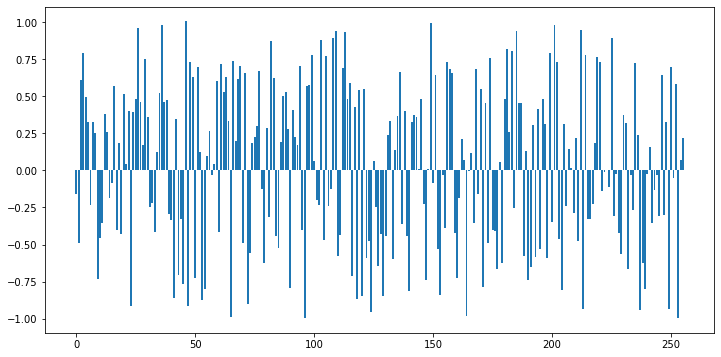

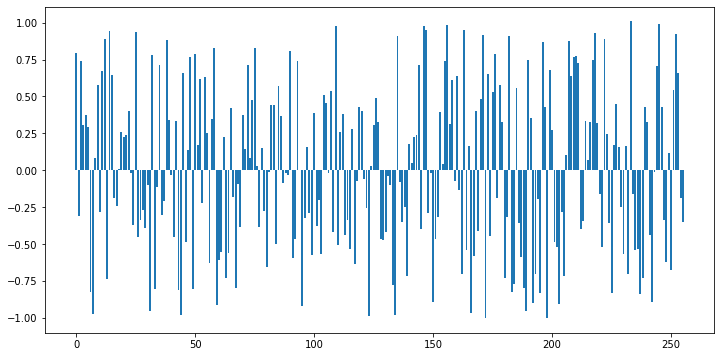

In [20]:
fig = plt.figure(figsize=(12,6))
plt.bar(np.arange(256), model.net.coord_linears[0].weight.data.cpu().numpy().reshape(-1))
fig = plt.figure(figsize=(12,6))
plt.bar(np.arange(256), model.net.coord_linears[1].weight.data.cpu().numpy().reshape(-1))

Bias

<BarContainer object of 256 artists>

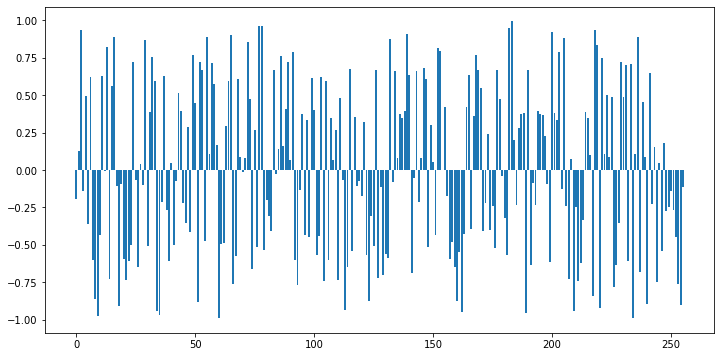

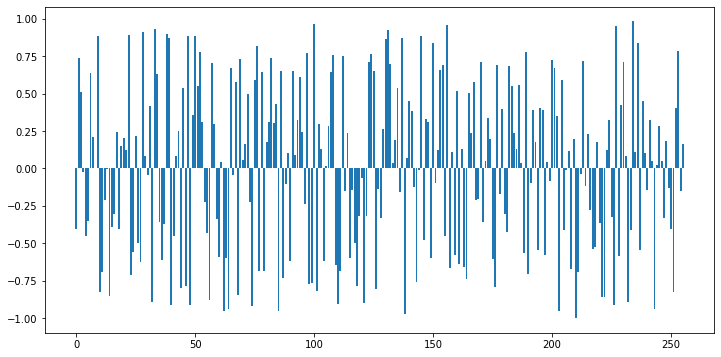

In [21]:
fig = plt.figure(figsize=(12,6))
plt.bar(np.arange(256), model.net.coord_linears[0].bias.data.cpu().numpy().reshape(-1))
fig = plt.figure(figsize=(12,6))
plt.bar(np.arange(256), model.net.coord_linears[1].bias.data.cpu().numpy().reshape(-1))

In [63]:
in_zero = torch.tensor([0.]).cuda().reshape([1,1])
in_range = torch.linspace(-1,1,512).cuda().reshape([512,1])

In [64]:
def get_feature(in_pts, ch_id):
    h = model.net.coord_linears[ch_id](in_pts)
    h = model.net.coord_nl(h)
    h = model.net.net(h)
    return h

In [65]:
with torch.no_grad():
    h_x = get_feature(in_range, 0)
    h_y = get_feature(in_range, 1)

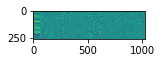

In [66]:
fig = plt.figure(figsize=(2,32))
plt.imshow(model.net.coord_nl(torch.cat([h_x,h_y],0)).data.cpu().t().numpy())

In [70]:
out = (((h_x.unsqueeze(1) * h_y.unsqueeze(0)).sum(-1) + 1)/2).clamp(0,1).cpu().numpy()

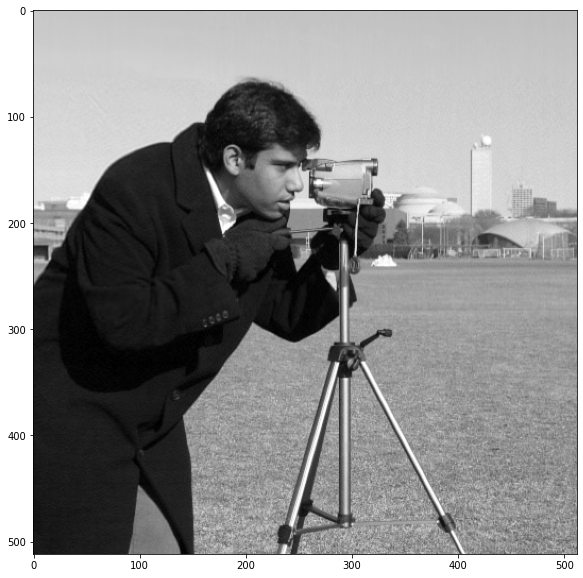

In [72]:
plt.figure(figsize=(10,10))
plt.imshow(out, cmap='gray')